<a href="https://colab.research.google.com/github/Soufianelotfi-lab/Classification_Formes_Ondes_6G/blob/main/CNN_BiLSTM_Attn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation & importation des bibliothèques + choix du device (GPU/CPU)

In [ ]:
!pip install scipy scikit-learn tqdm -q

import numpy as np  # calcul numérique (tableaux, reshape, stats)
import scipy.io as sio # lire les fichiers MATLAB .mat (loadmat)
import torch   # base PyTorch (tensor + GPU)
import torch.nn as nn   # modules réseau (couches, loss)
import torch.optim as optim  # optimiseurs (Adam, SGD, ...)

from torch.utils.data import Dataset, DataLoader  # Dataset + DataLoader
from sklearn.model_selection import train_test_split   # split train/val/test
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report  # métriques

import matplotlib.pyplot as plt    # figures (loss/accuracy, matrice de confusion)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # si un GPU est disponible, on utilise "cuda", sinon "cpu"
print(" Device :", device)
print(" Torch version :", torch.__version__)


 Device : cuda
 Torch version : 2.9.0+cu126


Montage du Google Drive + vérification du chemin du dataset

In [ ]:
from google.colab import drive  # accéder à Google Drive dans Colab
import os                       # gérer fichiers/dossiers (exists, listdir)

drive.mount("/content/drive")  # Monter le Drive dans /content/drive


signals_path = "/content/drive/MyDrive/5ème/Projet_techno/data_set_40k.mat" # Chemin exact vers mon fichier .mat (copié depuis Drive)

# Vérifie si le fichier existe vraiment à cet endroit
print(" Exists ?", os.path.exists(signals_path))
print(" Path :", signals_path)

# Afficher le contenu du dossier pour confirmer qu'on est dans le bon répertoire
folder = os.path.dirname(signals_path)     # récupère le dossier parent
print("\n Contenu du dossier :", folder)
print(os.listdir(folder)[:30])  # affiche 30 premiers fichiers


Mounted at /content/drive
 Exists ? True
 Path : /content/drive/MyDrive/5ème/Projet_techno/data_set_40k.mat

 Contenu du dossier : /content/drive/MyDrive/5ème/Projet_techno
['data_set_40k.mat']


In [ ]:
Chargement du fichier .mat + affichage des variables

In [ ]:
import scipy.io as sio

# Charger le .mat : retourne un dictionnaire {nom_variable: valeur}
mat = sio.loadmat(signals_path)

print(" Variables présentes dans le fichier .mat :")

# Filtrer les clés MATLAB internes (header, version, ...)
keys = [k for k in mat.keys() if not k.startswith("__")]
print(keys)

# Pour chaque variable utile : afficher type + shape
for k in keys:
    v = mat[k]
    print(f"\n🔹 Variable: {k}")
    print("   Type :", type(v))
    if hasattr(v, "shape"):
        print("   Shape:", v.shape)


📦 Variables présentes dans le fichier .mat :
['data_set']

🔹 Variable: data_set
   Type : <class 'numpy.ndarray'>
   Shape: (40000, 4096)


Extraction des signaux + normalisation + reshape en (N, 2, L)

In [ ]:
# Extraire la matrice de signaux depuis le dictionnaire
X = mat["data_set"]     # X est un np.ndarray
print("Shape initiale X :", X.shape)

# N = nombre de signaux, total_features = longueur totale (I+Q)
N, total_features = X.shape

# On vérifie que total_features est pair (car I et Q ont la même taille)
assert total_features % 2 == 0, "Le nombre de features doit être pair (I/Q)"

# L = longueur d'un seul canal (I ou Q)
L = total_features // 2

print("Nombre de signaux :", N)
print("Longueur par canal (I ou Q) :", L)

# Convertir en float32 (plus léger et standard pour PyTorch)
X = X.astype(np.float32)

# Normalisation PAR signal : mean=0 et std=1 sur l’axe des features
# stabilise l'entraînement (évite échelles différentes entre signaux)
Xn = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

# Reshape : (N, 4096) -> (N, 2, 2048)
# Axe 1 = canaux (I,Q), Axe 2 = temps
Xn = Xn.reshape(N, 2, L)

print(" Shape finale Xn :", Xn.shape)
print(" Type :", Xn.dtype)
print(" Stats globales : mean≈", float(Xn.mean()), " std≈", float(Xn.std()))


Shape initiale X : (40000, 4096)
Nombre de signaux : 40000
Longueur par canal (I ou Q) : 2048
 Shape finale Xn : (40000, 2, 2048)
 Type : float32
 Stats globales : mean≈ -9.853393101444397e-11  std≈ 0.9999982118606567


Création des labels Y (4 classes équilibrées)

In [ ]:
n_classes = 4
n_per_class = 10000

# Crée Y = [0..0, 1..1, 2..2, 3..3] (10000 de chaque)
Y = np.repeat(np.arange(n_classes), n_per_class).astype(np.int64)

print(" Shape Y :", Y.shape)
print(" Labels uniques :", np.unique(Y))
print("Début :", Y[:20])
print("Milieu :", Y[9995:10005], Y[19995:20005])  # transition 0->1 puis 1->2
print("Fin :", Y[-20:])


 Shape Y : (40000,)
 Labels uniques : [0 1 2 3]
Début : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Milieu : [0 0 0 0 0 1 1 1 1 1] [1 1 1 1 1 2 2 2 2 2]
Fin : [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


Split Train / Val / Test, en gardant l’équilibre des classes

---



In [ ]:
from sklearn.model_selection import train_test_split

#  Split Train 80% / Test 20% en gardant les proportions de classes
X_train, X_test, Y_train, Y_test = train_test_split(
    Xn, Y,
    test_size=0.20,
    random_state=42,
    stratify=Y,
    shuffle=True
)

#  Dans Train (80%), prendre 12.5% pour Validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train,
    test_size=0.125,
    random_state=42,
    stratify=Y_train,
    shuffle=True
)

print(" Split OK")
print("Train :", X_train.shape, Y_train.shape)
print("Val   :", X_val.shape, Y_val.shape)
print("Test  :", X_test.shape, Y_test.shape)

# Vérifier distribution des classes
def show_dist(y, name):
    u, c = np.unique(y, return_counts=True)
    print(f"{name} dist:", dict(zip(u, c)))

show_dist(Y_train, "Train")
show_dist(Y_val, "Val")
show_dist(Y_test, "Test")


 Split OK
Train : (28000, 2, 2048) (28000,)
Val   : (4000, 2, 2048) (4000,)
Test  : (8000, 2, 2048) (8000,)
Train dist: {np.int64(0): np.int64(7000), np.int64(1): np.int64(7000), np.int64(2): np.int64(7000), np.int64(3): np.int64(7000)}
Val dist: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000), np.int64(2): np.int64(1000), np.int64(3): np.int64(1000)}
Test dist: {np.int64(0): np.int64(2000), np.int64(1): np.int64(2000), np.int64(2): np.int64(2000), np.int64(3): np.int64(2000)}


Dataset PyTorch + DataLoaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class WaveformDataset(Dataset):
    def __init__(self, X, Y):
      # Convertit les numpy arrays en tensors PyTorch
        self.X = torch.tensor(X, dtype=torch.float32)  # signaux en float32
        self.Y = torch.tensor(Y, dtype=torch.long)     # labels en int64 (obligatoire pour CrossEntropy)

    def __len__(self):
      # Nombre d'exemples
        return len(self.X)

    def __getitem__(self, idx):
       # Retourne un exemple (signal, label)
        return self.X[idx], self.Y[idx]
# Créer les datasets

train_ds = WaveformDataset(X_train, Y_train)
val_ds   = WaveformDataset(X_val,   Y_val)
test_ds  = WaveformDataset(X_test,  Y_test)

batch_size = 128

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, pin_memory=True)

print(" DataLoaders prêts")

# Vérification rapide : forme d’un batch
xb, yb = next(iter(train_loader))
print("xb shape:", xb.shape)  # (128, 2, 2048)
print("yb shape:", yb.shape)  # (128,)
print("labels uniques dans batch:", torch.unique(yb))


 DataLoaders prêts
xb shape: torch.Size([128, 2, 2048])
yb shape: torch.Size([128])
labels uniques dans batch: tensor([0, 1, 2, 3])


Architecture du modèle (CNN + BiLSTM + Attention + Dense)

In [ ]:
import torch
import torch.nn as nn

class CNN_BiLSTM_Attn(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

         # CNN 1D : extrait des motifs locaux dans I/Q
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=9, padding=4),  # (B,2,2048) -> (B,64,2048)
            nn.BatchNorm1d(64),     # stabilise l'entraînement
            nn.ReLU(), # non-linéarité

            nn.Conv1d(64, 128, kernel_size=7, padding=3),  # -> (B,128,2048)
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.MaxPool1d(2),  # réduit la longueur : 2048 -> 1024
            nn.Dropout(0.25)  # régularisation (évite overfitting)
        )

         #  BiLSTM : capture la dépendance temporelle
        self.lstm = nn.LSTM(
            input_size=128,   # chaque pas de temps a 128 features (sortie CNN)
            hidden_size=64,   # taille mémoire interne
            num_layers=1,
            batch_first=True, # entrée sous forme (B, T, F)
            bidirectional=True # entrée sous forme (B, T, F)
        )

        # Attention : apprend quels instants sont importants
        self.attn = nn.Linear(128, 1)  # 128 = 64*2 (bidirectionnel)

        #  Dense : classification finale
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.30),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (B, 2, 2048)
        x = self.cnn(x)          # (B, 128, 1024)
       # LSTM attend (B, T, F) donc on transpose
        x = x.transpose(1, 2)    # (B, 1024, 128) -> séquence pour LSTM

        # h: sorties de la BiLSTM pour chaque pas de temps

        h, _ = self.lstm(x)      # (B, 1024, 128)

        # Attention : score par pas de temps, puis softmax (poids qui somme à 1)
        w = torch.softmax(self.attn(h), dim=1)   # (B, 1024, 1)

        # Context = somme pondérée des états h
        context = (w * h).sum(dim=1)             # (B, 128)

        # Logits de classification
        out = self.fc(context)   # (B, 4)
        return out


# Instancier le modèle et l’envoyer sur device (CPU/GPU)
model = CNN_BiLSTM_Attn(num_classes=4).to(device)
print(model)

# Vérification forward (juste pour vérifier les dimensions)
xb, yb = next(iter(train_loader))
xb = xb.to(device)

with torch.no_grad():
    logits = model(xb)

print(" Forward OK | logits shape:", logits.shape)


CNN_BiLSTM_Attn(
  (cnn): Sequential(
    (0): Conv1d(2, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.25, inplace=False)
  )
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=4, 

Entraînement (30 epochs) + stockage des courbes dans history

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn

epochs = 30

# Fonction de coût : CrossEntropy pour classification multi-classes
criterion = nn.CrossEntropyLoss()

# Optimiseur : AdamW (Adam + weight decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()    # mode entraînement (dropout actif)
    total_loss = 0.0
    all_preds, all_true = [], []

    for xb, yb in loader:   # boucle sur les batches
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()  # remet à 0 les gradients
        logits = model(xb)     # forward
        loss = criterion(logits, yb)  # calcule la loss
        loss.backward()     # backpropagation
        optimizer.step()    # update des poids

        total_loss += loss.item() * xb.size(0)  # somme pondérée par batch
        preds = torch.argmax(logits, dim=1)     # classe prédite

        all_preds.append(preds.detach().cpu())
        all_true.append(yb.detach().cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_true  = torch.cat(all_true).numpy()
    acc = accuracy_score(all_true, all_preds)

    return total_loss / len(loader.dataset), acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()   # mode évaluation (dropout OFF)
    total_loss = 0.0
    all_preds, all_true = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_true  = torch.cat(all_true).numpy()
    acc = accuracy_score(all_true, all_preds)

    return total_loss / len(loader.dataset), acc

# IMPORTANT : history sert pour tracer les courbes après
history = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

print(" Training start (30 epochs, no early stopping)")
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)

    history["tr_loss"].append(tr_loss)
    history["tr_acc"].append(tr_acc)
    history["va_loss"].append(va_loss)
    history["va_acc"].append(va_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")


 Training start (30 epochs, no early stopping)
Epoch 01/30 | train loss 0.8906 acc 0.4883 | val loss 0.8256 acc 0.5000
Epoch 02/30 | train loss 0.8279 acc 0.4988 | val loss 0.8241 acc 0.5000
Epoch 03/30 | train loss 0.8253 acc 0.5039 | val loss 0.8242 acc 0.5000
Epoch 04/30 | train loss 0.8252 acc 0.5026 | val loss 0.8246 acc 0.5000
Epoch 05/30 | train loss 0.8250 acc 0.5042 | val loss 0.8240 acc 0.5000
Epoch 06/30 | train loss 0.8250 acc 0.5020 | val loss 0.8240 acc 0.5015
Epoch 07/30 | train loss 0.8250 acc 0.5002 | val loss 0.8239 acc 0.5000
Epoch 08/30 | train loss 0.8244 acc 0.5036 | val loss 0.8256 acc 0.5000
Epoch 09/30 | train loss 0.8260 acc 0.5008 | val loss 0.8241 acc 0.5000
Epoch 10/30 | train loss 0.8248 acc 0.5004 | val loss 0.8241 acc 0.5000
Epoch 11/30 | train loss 0.8248 acc 0.5009 | val loss 0.8239 acc 0.4998
Epoch 12/30 | train loss 0.8243 acc 0.5041 | val loss 0.8244 acc 0.5000
Epoch 13/30 | train loss 0.8242 acc 0.5086 | val loss 0.8244 acc 0.4985
Epoch 14/30 | tra

Graphes Loss & Accuracy + meilleure époque validation

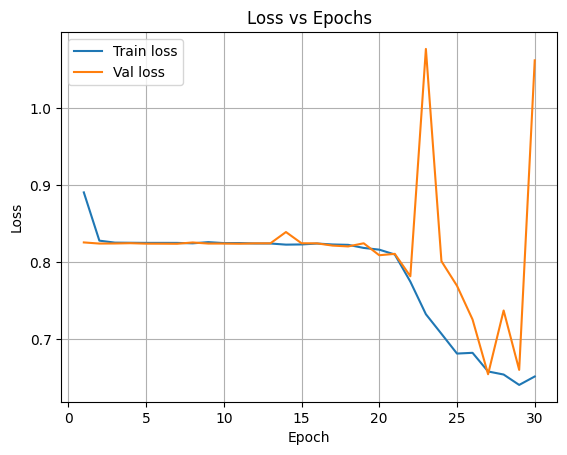

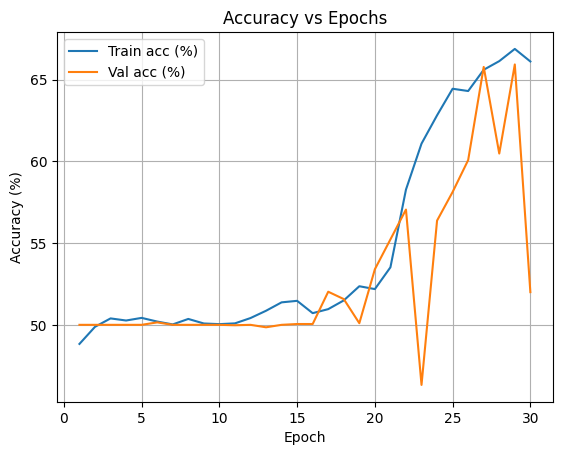

 Best Val Acc = 0.6593 at epoch 29


In [ ]:
import matplotlib.pyplot as plt

epochs_r = range(1, len(history["tr_loss"]) + 1)

# Courbe Loss
plt.figure()
plt.plot(epochs_r, history["tr_loss"], label="Train loss")
plt.plot(epochs_r, history["va_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Courbe Accuracy
plt.figure()
plt.plot(epochs_r, [a*100 for a in history["tr_acc"]], label="Train acc (%)")
plt.plot(epochs_r, [a*100 for a in history["va_acc"]], label="Val acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Meilleure epoch validation
best_epoch = int(np.argmax(history["va_acc"])) + 1
best_val = float(np.max(history["va_acc"]))
print(f" Best Val Acc = {best_val:.4f} at epoch {best_epoch}")


Évaluation finale sur TEST : Accuracy + matrice de confusion + classification report

 TEST accuracy : 0.509875


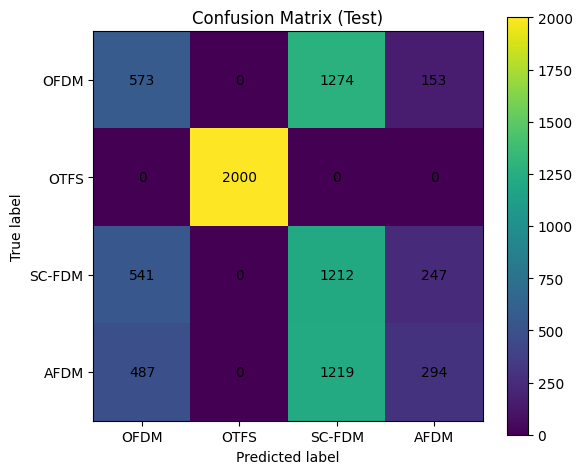


 Classification report (Test):

              precision    recall  f1-score   support

        OFDM     0.3579    0.2865    0.3182      2000
        OTFS     1.0000    1.0000    1.0000      2000
      SC-FDM     0.3271    0.6060    0.4249      2000
        AFDM     0.4236    0.1470    0.2183      2000

    accuracy                         0.5099      8000
   macro avg     0.5272    0.5099    0.4903      8000
weighted avg     0.5272    0.5099    0.4903      8000



In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Prédire sur le TEST
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)


#  Accuracy + confusion matrix
acc_test = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(" TEST accuracy :", acc_test)

#  matrice
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.colorbar()

tick_marks = np.arange(4)
classes = ["OFDM", "OTFS", "SC-FDM", "AFDM"]  # ordre des classes
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# écrire les valeurs dans chaque case
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


#  Classification report (precision/recall/f1 par classe)
print("\n Classification report (Test):\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))
